### **Read Data**

**Station KR289**

In [679]:
import pandas as pd
data =  pd.read_csv("D:\Min\Research Topic\Task\KR289.csv")

In [680]:
data["Pcp"].fillna(0, inplace=True)

In [681]:
data = data[(data.year >= 1980) & (data.year != 2019)]

In [682]:
data.head()

,year,month,day,Pcp,Tmax,Tmin,Wspeed,Rhumidity,Srad,Sshine,Cloud,Tavg
2833,1980,1,1,1.1,5.8,1.3,0.2,0.908,-99.0,0.0,10.0,3.6
2834,1980,1,2,7.3,6.8,3.8,0.1,0.945,-99.0,0.0,10.0,5.4
2835,1980,1,3,0.5,9.2,5.6,1.6,0.845,-99.0,0.4,10.0,7.0
2836,1980,1,4,0.0,6.2,-2.1,3.8,0.498,-99.0,6.2,4.3,3.5
2837,1980,1,5,0.0,3.0,-5.9,2.3,0.525,-99.0,7.9,0.0,-2.3


In [683]:
data = data[["year", "month", "day", "Pcp", "Rhumidity","Tavg", "Tmax", "Tmin"]]
data = data.dropna()

In [684]:
data.head()

,year,month,day,Pcp,Rhumidity,Tavg,Tmax,Tmin
2833,1980,1,1,1.1,0.908,3.6,5.8,1.3
2834,1980,1,2,7.3,0.945,5.4,6.8,3.8
2835,1980,1,3,0.5,0.845,7.0,9.2,5.6
2836,1980,1,4,0.0,0.498,3.5,6.2,-2.1
2837,1980,1,5,0.0,0.525,-2.3,3.0,-5.9


In [685]:
data  = data[data['Rhumidity'] != -99.0]

In [686]:
data['Rhumidity'] = data.apply(lambda row: row['Rhumidity'] * 100 if row['year'] < 2019 else row['Rhumidity'], axis=1)

**Drop rows with NAN**

In [687]:
data.shape

(15337, 8)

### **Calculate Dewpoint temperaature**

In [688]:
import math
def calculate_dewpoint(temp, humidity):
    A = 17.27
    B = 237.7
    alpha = ((A * temp) / (B + temp)) + math.log(humidity/100.0)
    return (B * alpha) / (A - alpha)

In [689]:
data['Tdew'] = data.apply(lambda row: calculate_dewpoint(row['Tavg'], row['Rhumidity']), axis=1)
data.head()

,year,month,day,Pcp,Rhumidity,Tavg,Tmax,Tmin,Tdew
2833,1980,1,1,1.1,90.8,3.6,5.8,1.3,2.238829
2834,1980,1,2,7.3,94.5,5.4,6.8,3.8,4.588320
2835,1980,1,3,0.5,84.5,7.0,9.2,5.6,4.567805
2836,1980,1,4,0.0,49.8,3.5,6.2,-2.1,-5.991340
2837,1980,1,5,0.0,52.5,-2.3,3.0,-5.9,-10.688035


In [690]:
data['Date'] = pd.to_datetime(data[['year', 'month', 'day']], errors='coerce')

In [691]:
data.head()

,year,month,day,Pcp,Rhumidity,Tavg,Tmax,Tmin,Tdew,Date
2833,1980,1,1,1.1,90.8,3.6,5.8,1.3,2.238829,1980-01-01
2834,1980,1,2,7.3,94.5,5.4,6.8,3.8,4.588320,1980-01-02
2835,1980,1,3,0.5,84.5,7.0,9.2,5.6,4.567805,1980-01-03
2836,1980,1,4,0.0,49.8,3.5,6.2,-2.1,-5.991340,1980-01-04
2837,1980,1,5,0.0,52.5,-2.3,3.0,-5.9,-10.688035,1980-01-05


### **Binning Method**

In [692]:
# Define the precipitation intensity threshold for rain days
precipitation_threshold = 0.1

rain_days = data[data['Pcp'] > precipitation_threshold]

num_bins = 20

In [693]:
# Apply equal-frequency binning to the temperature data for rain days
rain_days['Temperature_Bins'] = pd.qcut(rain_days['Tdew'], q=num_bins, labels=False, duplicates='drop')

C:\Users\USER2\AppData\Local\Temp\ipykernel_15256\3368197447.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rain_days['Temperature_Bins'] = pd.qcut(rain_days['Tdew'], q=num_bins, labels=False, duplicates='drop')


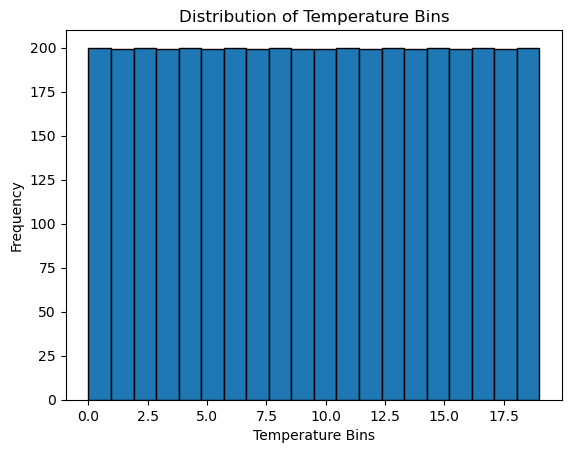

In [694]:
import matplotlib.pyplot as plt
bin_counts = rain_days['Temperature_Bins'].value_counts().sort_index()
plt.hist(rain_days['Temperature_Bins'], bins=num_bins, edgecolor='black')
plt.xlabel('Temperature Bins')
plt.ylabel('Frequency')
plt.title('Distribution of Temperature Bins')
plt.show()

In [695]:
# Calculate P99 for precipitation in each temperature bin
p99_precipitation = rain_days.groupby('Temperature_Bins')['Pcp'].quantile(0.99)

# Calculate mean temperature in each bin
mean_dew_temperature = rain_days.groupby('Temperature_Bins')['Tdew'].mean()

result_df = pd.DataFrame({'Mean_Dew_Temperature': mean_dew_temperature, 'P99_Precipitation': p99_precipitation})

result_df

,Mean_Dew_Temperature,P99_Precipitation
Temperature_Bins,,
0,-6.772735,13.050
1,-2.074207,31.588
2,0.428707,33.533
3,2.389970,39.584
4,4.421596,40.505
5,6.588461,59.020
6,8.425504,69.735
7,10.294340,86.634
8,12.039077,80.592


**Fit log(P99) and Mean Dew in each bin to estimate beta**

$log(P99) = \alpha + \beta T$

In [696]:
import numpy as np

result_df['Log_P99'] = np.log(result_df['P99_Precipitation'])

In [697]:
result_df

,Mean_Dew_Temperature,P99_Precipitation,Log_P99
Temperature_Bins,,,
0,-6.772735,13.050,2.568788
1,-2.074207,31.588,3.452777
2,0.428707,33.533,3.512530
3,2.389970,39.584,3.678425
4,4.421596,40.505,3.701425
5,6.588461,59.020,4.077876
6,8.425504,69.735,4.244702
7,10.294340,86.634,4.461692
8,12.039077,80.592,4.389399


In [698]:
from scipy.stats import linregress
import matplotlib.pyplot as plt

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(result_df['Mean_Dew_Temperature'], result_df['Log_P99'])

In [699]:
slope

0.0826278778175079

**Calculate Scaling Rate**

$100(e^\beta-1)$

In [700]:
scaling_rate_tdew = 100*((math.e)**(slope) - 1)

In [701]:
scaling_rate_tdew 

8.613755745913586

### **Quantile Regression**

In [702]:
import statsmodels.api as sm

quantile = 0.99

model_Pcp = sm.QuantReg(np.log(rain_days['Pcp']), sm.add_constant(rain_days[['Tdew']])).fit(q=quantile)

In [703]:
print(model_Pcp.summary())

                         QuantReg Regression Results                          
Dep. Variable:                    Pcp   Pseudo R-squared:               0.1323
Model:                       QuantReg   Bandwidth:                      0.5900
Method:                 Least Squares   Sparsity:                        25.65
Date:                Sun, 17 Dec 2023   No. Observations:                 3990
Time:                        14:10:13   Df Residuals:                     3988
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5271      0.066     53.056      0.000       3.397       3.657
Tdew           0.0850      0.004     20.407      0.000       0.077       0.093


In [704]:
slope = model_Pcp.params[1]

In [705]:
scaling_rate = 100*((math.e)**(slope) - 1)
scaling_rate 

8.873320356414105

### **Zhang Method**

In [706]:
grouped_df = data.groupby(['year', 'month'])

max_indices = grouped_df.apply(lambda x: x['Pcp'].idxmax())

monthly_max = data.loc[max_indices]

In [707]:
wet_day = data[data["Pcp"] > 0]
mean_tdew = wet_day.groupby(['year', 'month'])['Tdew'].mean().reset_index()
mean_tdew = mean_tdew.rename(columns = {'Tdew':'mean_tdew'})

In [708]:
wet_day = data[data["Pcp"] > 0]
mean_tavg = wet_day.groupby(['year', 'month'])['Tavg'].mean().reset_index()
mean_tavg = mean_tavg.rename(columns = {'Tavg':'mean_Tavg'})

In [709]:
monthly_max = pd.merge(monthly_max, mean_tdew, on=['year', 'month'])
monthly_max = pd.merge(monthly_max, mean_tavg, on=['year', 'month'])

In [710]:
monthly_max

,year,month,day,Pcp,Rhumidity,Tavg,Tmax,Tmin,Tdew,Date,mean_tdew,mean_Tavg
0,1980,1,28,18.3,92.5,6.4,12.1,2.9,5.273618,1980-01-28,-0.167620,3.090000
1,1980,2,29,5.2,77.3,4.5,13.4,-4.0,0.875767,1980-02-29,-0.065610,3.466667
2,1980,3,9,23.6,82.3,7.4,9.0,5.8,4.582072,1980-03-09,2.859284,7.362500
3,1980,4,5,83.3,89.5,15.8,19.1,14.3,14.075256,1980-04-05,6.969364,11.518182
4,1980,5,12,29.2,79.5,16.7,18.9,14.8,13.133846,1980-05-12,12.945473,17.176923
...,...,...,...,...,...,...,...,...,...,...,...,...
494,2022,8,1,74.2,94.9,25.6,26.4,25.0,24.718927,2022-08-01,23.607498,25.280000
495,2022,9,6,75.1,75.8,22.1,25.9,17.0,17.622869,2022-09-06,20.849970,22.557143
496,2022,10,4,25.5,79.6,21.7,26.6,16.5,18.013333,2022-10-04,10.782832,14.980000
497,2022,11,28,39.6,88.0,8.6,12.8,3.4,6.725294,2022-11-28,7.472560,10.862500


In [711]:
monthly_max = monthly_max.drop(["Rhumidity","Tmax", "Tmin", "Date"], axis = 1)

In [712]:
monthly_max.head()

,year,month,day,Pcp,Tavg,Tdew,mean_tdew,mean_Tavg
0,1980,1,28,18.3,6.4,5.273618,-0.167620,3.090000
1,1980,2,29,5.2,4.5,0.875767,-0.065610,3.466667
2,1980,3,9,23.6,7.4,4.582072,2.859284,7.362500
3,1980,4,5,83.3,15.8,14.075256,6.969364,11.518182
4,1980,5,12,29.2,16.7,13.133846,12.945473,17.176923


In [713]:
monthly_max = monthly_max[monthly_max['Pcp'] != 0]

In [714]:
monthly_max.head()

,year,month,day,Pcp,Tavg,Tdew,mean_tdew,mean_Tavg
0,1980,1,28,18.3,6.4,5.273618,-0.167620,3.090000
1,1980,2,29,5.2,4.5,0.875767,-0.065610,3.466667
2,1980,3,9,23.6,7.4,4.582072,2.859284,7.362500
3,1980,4,5,83.3,15.8,14.075256,6.969364,11.518182
4,1980,5,12,29.2,16.7,13.133846,12.945473,17.176923


### **Fit with corresponding Tdew**

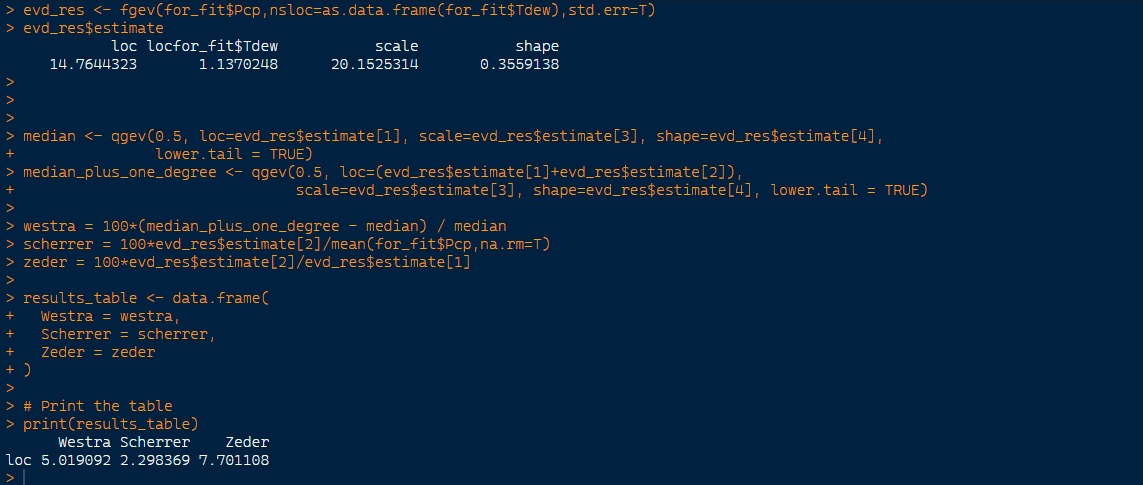

In [715]:
from IPython.display import Image
image_path = "tdew.png"
Image(filename=image_path)

### **Fit with corresponding Tavg**

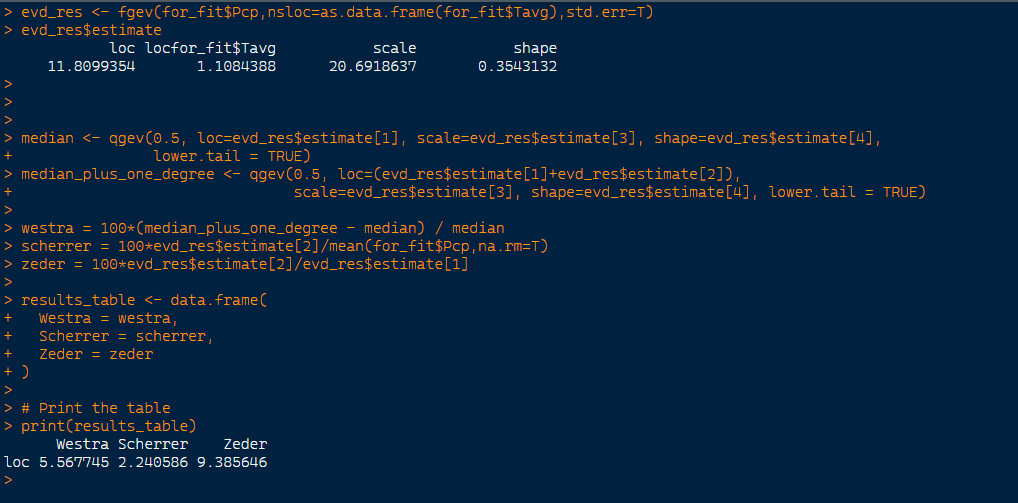

In [716]:
image_path = "tavg.png"
Image(filename=image_path)

### **Fit with monthly average of Tdew**

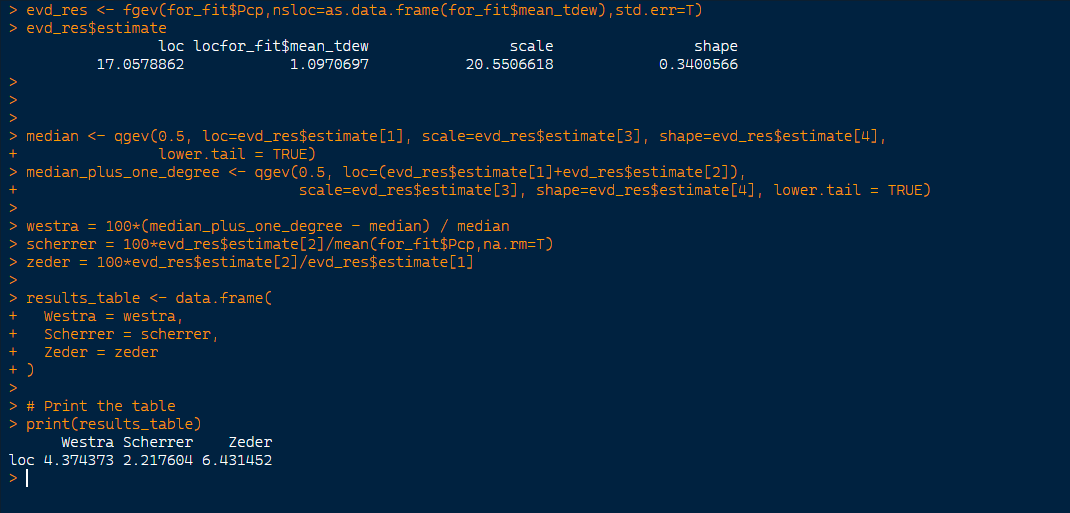

In [717]:
image_path = "mean_tdew.png"
Image(filename=image_path)

### **Fit with monthly average of Tavg**

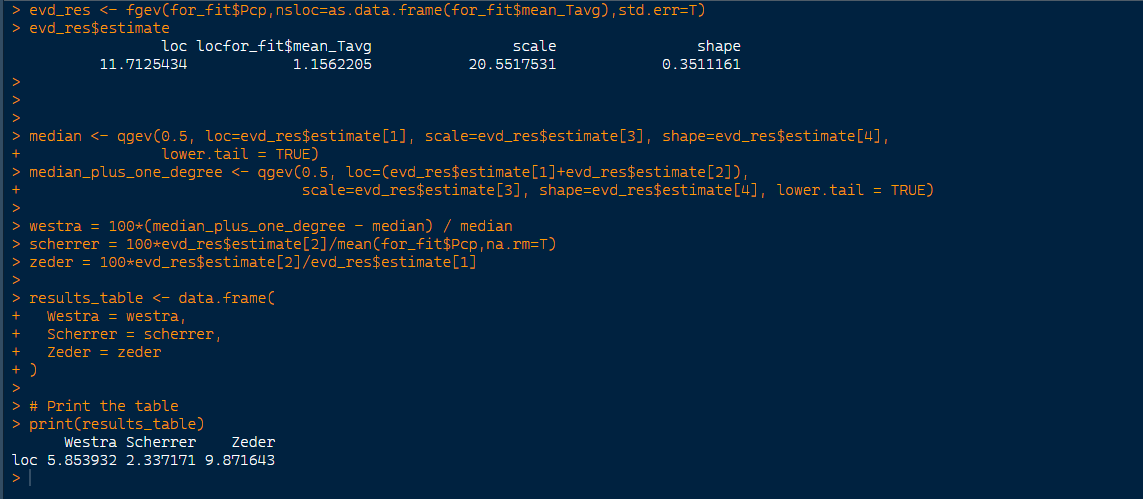

In [718]:
image_path = "mean_tavg.png"
Image(filename=image_path)

### **Plot the Relationship**

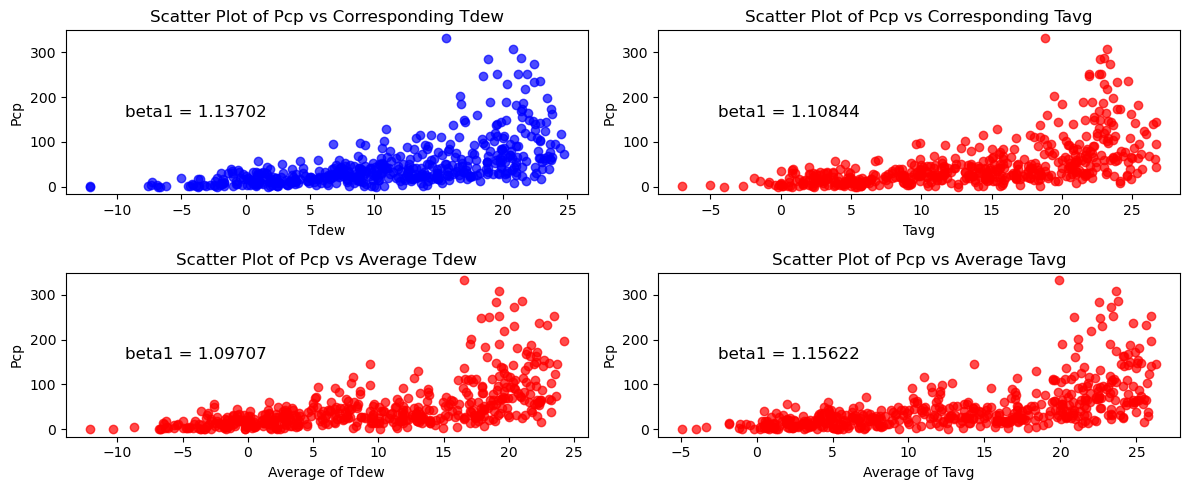

In [719]:
import matplotlib.pyplot as plt

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))

# Scatter plot 1
ax1 = axes[0, 0]
ax1.scatter(monthly_max['Tdew'], monthly_max['Pcp'], label='Pcp vs Corresponding Tdew', color='blue', alpha=0.7)
ax1.set_xlabel('Tdew')
ax1.set_ylabel('Pcp')
ax1.set_title('Scatter Plot of Pcp vs Corresponding Tdew')
ax1.text(0.25, 0.5, f"beta1 = {1.1370248:.5f}", transform=ax1.transAxes, fontsize=12, ha='center', va='center')

# Scatter plot 2
ax2 = axes[0, 1]
ax2.scatter(monthly_max['Tavg'], monthly_max['Pcp'], label='Pcp vs Corresponding Tavg', color='red', alpha=0.7)
ax2.set_xlabel('Tavg')
ax2.set_ylabel('Pcp')
ax2.set_title('Scatter Plot of Pcp vs Corresponding Tavg')
ax2.text(0.25, 0.5, f"beta1 = {1.1084388:.5f}", transform=ax2.transAxes, fontsize=12, ha='center', va='center')

# Scatter plot 3
ax3 = axes[1, 0]
ax3.scatter(monthly_max['mean_tdew'], monthly_max['Pcp'], label='Pcp vs Average Tdew', color='red', alpha=0.7)
ax3.set_xlabel('Average of Tdew')
ax3.set_ylabel('Pcp')
ax3.set_title('Scatter Plot of Pcp vs Average Tdew')
ax3.text(0.25, 0.5, f"beta1 = {1.0970697:.5f}", transform=ax3.transAxes, fontsize=12, ha='center', va='center')

# Scatter plot 4
ax4 = axes[1, 1]
ax4.scatter(monthly_max['mean_Tavg'], monthly_max['Pcp'], label='Pcp vs Average Tavg', color='red', alpha=0.7)
ax4.set_xlabel('Average of Tavg')
ax4.set_ylabel('Pcp')
ax4.set_title('Scatter Plot of Pcp vs Average Tavg')
ax4.text(0.25, 0.5, f"beta1 = {1.1562205:.5f}", transform=ax4.transAxes, fontsize=12, ha='center', va='center')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

